# Lab 2 classification

In this lab we're tackling one of machine learning most common tasks: classification. The classification task at hand is a very simple sentiment classifier. We have taken a subset of the reviews dataset containing only very negative or very positive reviews. The goal is to use these reviews to train a classification model that can classify reviews as positive or negative.

We will explore two different simple classification models: **K-nearest neighbors** and **logistic regression**. These two are typical examples for two families of machine learning:
- **Instance-based learning** have no fixed number of parameters, instead the number of parameters grows with the amount of training data. A typical example is K-nearest neighbors.
- **Model-based learning** have a fixed number of parameters that are trained. Examples of parametric models are linear regression, logistic regression, SVMs, neural networks, ...

To classify data, we model **decision boundaries**, boundaries in high dimensional space that separate the different classes the best as possible. Usually, these boundaries are not perfect so we will again need some **performance metrics** to quantify how good our classification is.

In case we are distinguishing between two classes (e.g. spam or not) we are performing **binary classification**, if we are distinguishing between multiple classes, it is called **multi-class classification**. In the binary classification case we often use the terms **postive and negative examples** to indicate whether they belong to the class or not.

To save you some time you get the data for free, we have already done some preprocessing and selected an english subset of the data with all the most negative and most positive data. We also added an extra feature sentiment which has value 1 for positive reviews and 0 for negative reviews.

<font color='red'>Task: take a look at the data? Are there as many postive as negative reviews? Try to mitigate any unwanted problems in the data</font>

In [162]:
import pandas as pd
from sklearn.utils import resample
import numpy as np

df = pd.read_csv("tripadvisor_dataset/reviews_sentiment.csv")


print(df["sentiment"].value_counts())
df = df.append([df[df['sentiment'] == 0]] * 7, ignore_index=True)
print(df["sentiment"].value_counts())

df = df.sample(n=1000)


1.0    12704
0.0     1538
Name: sentiment, dtype: int64
1.0    12704
0.0    12304
Name: sentiment, dtype: int64


C:\Users\hikma\AppData\Local\Temp\ipykernel_13448\30660174.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([df[df['sentiment'] == 0]] * 7, ignore_index=True)


As always, we'll also have to make a train and test set. This time instead of just picking them randomly, try to ensure that reviews of the same restaurant are not spread over the train and test set. This way we can prevent the model from possibly just learning to associate the name of a restaurant in a review with either good or bad.

<font color='red'>Task: Split the data in a train test set, make sure that the test set contains reviews of different restaurants than the test set. Hint: look at scikit-learns's GroupShuffleSplit!</font>

In [163]:
from sklearn.model_selection import GroupShuffleSplit 

# make a train test split
gss = GroupShuffleSplit(n_splits=2, train_size=0.8)
gss.get_n_splits()

a, b = next(gss.split(df, groups=df.id))
a
# x_train, x_test, y_train, y_test
x_train = df.iloc[a].drop(columns=["sentiment"])
x_test = df.iloc[b].drop(columns=["sentiment"])
y_train = df.iloc[a].sentiment
y_test = df.iloc[b].sentiment

Now that the data is split, we'll have to prepare it for processing. Take a look at the techniques of last lab and apply them to get TF IDF values of the reviews. 

<font color='red'>Task: get TFIDF values of the reviews in the dataset</font>

In [164]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.5
)

X_train_counts = count_vect.fit_transform(x_train["review"])

tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts)
# features = X_train_tf[0]

# feature_names=count_vect.get_feature_names_out()

# terms = pd.DataFrame(features.T.todense(), index=feature_names, columns=["tfidf"])
# terms.sort_values(by=["tfidf"],ascending=False).head(n=10)

## KNN classification

Now that we have our data ready, we can move onto training classification models. K-nearest neighbors (**k-nn**) is arguably one of the simplest classification models you can think of. It simply looks at the $K$ points in the training set that are the most similar to the test input, counts how many members of each class are in this set and returns that fraction as the estimate. K-nearest neighbors is an example of **memory-based learning** or **instance based learning**. These models have to store the training data in some sort of lookup table and try to **generalize** from this. The special case when $K=1$ is called the **nearest neighbor classifier**.

## Distance metrics
To determine which points in the training set are the closest to the test sample, we need to define some kind of **distance metric**. A distance metric returns a single value that is smaller if two points are similar. A distance metric $d$ has to satisfy to following properties:
- **Positivity**: $d(x, y) \geq 0$ for all $x$ and $y$
- **Identity**: $d(x,y)=0$ if and only if $x=y$
- **Symmetry**: $d(x,y) = d(y,x)$ for all $x$ and $y$
- **Triangle inequality**: $d(x,y) \leq d(x,z) + d(z, y)$ for all $x$, $y$, $z$

Some typical examples of distance metrics are the **Euclidean distance**, the **Manhattan distance** or the generalized **$L_k$** distance. Some other commonly used measures like the **cosine similarity** do not meet these criteria and are therefore not a distance metric although they are still very useful for certain problems. Cosine similarity is for example commonly used for sentiment analysis in text documents.

The $L_k$ distance metric or **norm** is defined as: $d_k(p, q) = \sqrt[k]{\sum_{i=1}^{d} |p_i - q_i|^k}$

The parameter $k$ provides a way to trade off between the largest and the total dimensional differences:
- **$k = 1$**: The distance is the sum of the absolute values of the differences along each dimension. This is often called the **Manhattan distance** or **City-block distance**.
- **$k = 2$**: The most common distance metric. It puts more weight on the dimension with the largest difference. This version is called the **Euclidean distance**
- **$k = \infty$**: Returns the largest single dimensional difference as the distance.

## The algorithm
K-nn simply looks at the $K$ points in the training set that are the closest to the test input, counts how many members of each class are in this set and returns that fraction as the estimate. The naive way to find the $K$ neighbors would be to loop over the dataset, comparing every element with the query. This has an $O(n)$ complexity. A better choice would be to store the data in a **K-D tree** which allows for $O(\log n)$ operations on average.

<font color='red'>Task: Take a look at scikit-learns KNeighborsClassifier, how do they handle this problem? Then train an instance of this classifier on our data, you can use the default parameters for now</font>


In [165]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree


# train a basic knn model
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_tf, y_train)



KNeighborsClassifier(n_neighbors=4)

In [166]:


X_test_counts = count_vect.transform(x_test["review"])

X_test_tf = tf_transformer.transform(X_test_counts)


In [167]:
X_test_tf.shape

(185, 5652)

In [168]:
X_train_tf.shape

(815, 5652)

## Perfomance metrics

Once our model is trained, we need to evaluate it on the test data to determine how good it actually is. In the case of binary classification where we have a **positive** and a **negative** class, we distinguish between:
- **True positives** (TP): We predicted the positive class and it was indeed a positive example.
- **True negatives** (TN): We predicted the negative class and it was indeed a negative example.
- **False positives** (FP): We predicted the positive class but it was a negative example. 
- **False negatives** (FN): We predicted the negative class but it was a positive example.


Based on these measurements we can then define scores such as:
- **Accuracy** $= \frac{TP + TN}{TP + TN + FN + FP}$. The fraction of correctly classified examples.
- **Precision** $= \frac{TP}{TP+FP}$. What part of the examples that we predicted to be positive, were actually positive ?
- **Recall** $=\frac{TP}{TP + FN}$. What part of the positive examples have we predicted to be positive ? Also called **sensitivity** or **True positive rate**.
- **F1-score** $= 2*\frac{precision*recall}{precision+recall}$: The harmonic mean of precision and recall.
- **False positive rate** $=\frac{FP}{FP+TN}$: What part of the negative examples have we predicted to be positive ?
- **False negative rate** $=\frac{FN}{FN+TP}$ : What part of the positive examples have we predicted to be negative ?

Accuracy is the most natural metric but you have to be careful if the classes are not balanced since the classifier could then always return the label of the most common class without having learned anything useful. It is not always clear which metric is the most important for your problem. In the case of a search engine for example we can define True Positives as relevant search results that were returned to the user and False Negatives as relevant results that were not shown to the user. We could then argue that Recall is not that important as long as some of the positive results have been returned. Similarly, we could argue that Precision is not that important as long as some of the returned results were positive.

<font color='red'>Task: Calculate the accuracy, Precision, Recall and F-score for our classifier on the test set. Which metrics do you think are most important here?.</font>

In [169]:
predicted = knn.predict(X_test_tf)

In [170]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


accuracy = accuracy_score(y_test, predicted)

precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

F1 = f1_score(y_test, predicted)
accuracy

0.8540540540540541

Note that scikit-learn decides the class based on the majority of the neighbors, but what if you wanted the treshold to be different? For example as soon as 2 out of 5 neighbors are of the same class, that class should be the predicted class. This would obviously affect you TPR and and FPR. A nice way of visualising this is the ROC curve which shows the TPR and FPR for different thresholds. The area under this curve is often used as a metric as ideally this would be 1 and in the worst case (random accuracy) 0.5. 

We provide you with the ROC curve and the code to generate it. Note that this code may take a while to execute.

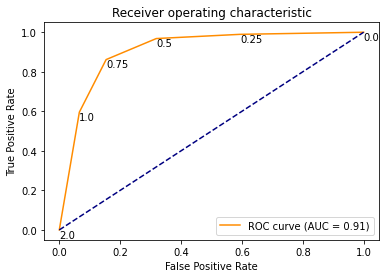

In [171]:
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import roc_curve, auc, accuracy_score


fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_tf)[:,1])
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, knn.predict(X_test_tf))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for x, y, txt in zip(fpr, tpr, thresholds):
    plt.annotate(np.round(txt,2), (x, y-0.04))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

<img src="images/ROC.png" width="400"  />

### Using grid search and cv to find the best hyperparameters

Up untill now we used a KNN classifier with the default hyperparameters. However, we might be able to get a better model with different hyperparameters.

<font color='red'>Task: use a grid search with cross validation to perform a hyperparameter search on you knn classifier, aferwards, reevaluate the best model on the test set</font>

In [172]:
from sklearn.model_selection import GridSearchCV

gcv = GridSearchCV(knn, param_grid={"n_neighbors": [15, 100]})
gcv.fit(X_train_tf, y_train)


GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=4),
             param_grid={'n_neighbors': [15, 100]})

In [173]:
# show best parameters and its performance
a = pd.DataFrame(gcv.cv_results_)
a

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001812,0.000408,0.008788,0.001304,15,{'n_neighbors': 15},0.883436,0.901840,0.889571,0.93865,0.901840,0.903067,0.019166,2
1,0.001587,0.000490,0.010809,0.001324,100,{'n_neighbors': 100},0.926380,0.889571,0.920245,0.93865,0.932515,0.921472,0.017090,1


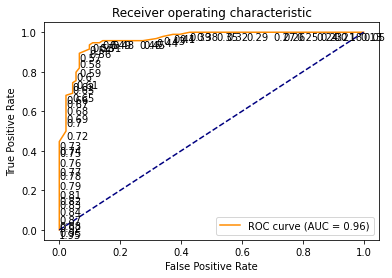

In [174]:
# construct ROC curve

fpr, tpr, thresholds = roc_curve(y_test, gcv.predict_proba(X_test_tf)[:,1])
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, gcv.predict(X_test_tf))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for x, y, txt in zip(fpr, tpr, thresholds):
    plt.annotate(np.round(txt,2), (x, y-0.04))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [175]:
# evaluate on test set
predicted = gcv.predict(X_test_tf)


In [176]:
accuracy = accuracy_score(y_test, predicted)

precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

F1 = f1_score(y_test, predicted)
precision

0.8811881188118812

Finally, let's try to take a look at the instances that were classified wrong, to get an idea of what went wrong.

In [177]:
mask = np.logical_not(np.equal(y_test, predicted))
# Now you can use the mask to see the elements bad classified:
# print(f"Elements wrong classified: {X_train_tf[mask]}")
# X_train_tf[0]

## Remarks
- Just like our linear regression model, k-nn models can be sensitive to **outliers**. Depending on your data, the model could benefit form **data cleaning** and **outlier removal** prior to training.
- There are many variants of the k-nn algorithm. A common variant is **Weighted k-nn** where the class is determined by weighted voting of the neighbors. The weights are determined by the distance to the test input.
- Since the complexity (both of storage and compute) scale with the number of training points, it might be a good idea to try to remove as much redundant training samples as possible. The goal is then to replace the training set by a **consistent subset**, a smaller set of training data that results in the same performance. There are many **heuristics** to determine this set.
- K-nn is a simple technique but is often a strong baseline. It has the added benefits that it is easily **interpretable** while still being able to model complex **non-linear decision boundaries**.
- We now used a k-nn model for classification but you can design a variant for regression. The value assigned to a query point is then computed based on the (weighted) mean of the values of its nearest neighbors.
- In this example we performed **binary classification** but in the more general case of **multiclass classification** it is always interesting to calculate a **confusion matrix** that shows how many examples of each class are classified as each class.

# 2. Logistic regression
Contrary to what the name suggests, **Logistic Regression** is not a regression model, it is a classification model. It is a modification of **linear regression** for **classification** problems. The trivial way to modify a regression model for classification is to encode the target as a number (0: negative review, 1: positive review) and to try to predict this actual value using regression. We could then interpret the predicted value (e.g. 0.8) as the probability of heart disease. Our linear regression model however is not limited to return numbers between 0 and 1, it can return any real number as a prediction. **Logistic regression** simply forces the output to be between 0 and 1 using a **logistic** or **sigmoid** function:

$f(x) = \frac{1}{1 + e^{-x}}$

Behind the scenes, logistic regression tries to find a **hyperplane** that separates the points of the different classes the best as possible. Depending on the side that a datapoint lies at, it is classified as a positive or a negative example. The distance of the point to the **decision boundary** is the output of the model and is rescaled to [0, 1] using the sigmoid function.

In the remainder of this lab you are going to implement a logistic regression model and train it with batch gradient descent which you also will implement.

<font color='red'>Task: Initialize a weight vector for the model. This has the same number of elements as the number of input features plus one extra weight for the bias. All values can be initialized to zero. Use numpy functions</font>

In [189]:


weights = np.zeros(X_train_tf.shape[0])
weights.shape

(815,)

<font color='red'>Task: write a function `predict` that calculates the output of the model for a given set of weights and input features. This is calculated by taking the dot product of the input with the weights. In the case of logistic regression, the output is then passed through a sigmoid to map the output to [0,1].</font>

In [190]:
def predict(weights, inputs):
    x = np.dot(weights, inputs)
    sigmoid = 1 / (1 + np.exp(-x))
    return sigmoid

X = np.hstack([np.ones((X_train_tf.shape[0], 1)), X_train_tf.toarray()])
predictions = predict(weights, X)


## Training

Gradient descent (sometimes also called **Steepest descent** is an iterative method that makes small changes to the weights during training until a good combination is found. To train our model, we use random values as our initial weights and calculate a **loss function** that indicates how good these weights are. We then calculate the **partial derivatives** of the loss function with respect to the weights of our model. These partial derivatives tell use whether we should increase or decrease the parameter value to reduce the loss. We then take small steps in these directions to obtain the new parameter values. This is repeated iteratively until good weights are found.

Gradient descent is commonly used in the case of **non-convex optimization** but in the case of Logistic regression we can force our problem to be convex by carefully choosing the loss function. We will use the **cross-entropy** or **negative log-likelihood loss** function as our loss function since this will result in a convex loss landscape where **mean squared error** would result in a non-convex loss. The cross entropy loss function is defined as 

$  cost = \begin{cases} 
      -log(h(x)) &  \text{if y=1} \\
      -log(1 - h(x)) & \text{if y=0}
   \end{cases}
$

Where $h(x)$ is the output of our model and y indicates whether the sample is positive or negative. The loss function can then be visualized as:

<img src="images/nll.png" width="400"  />

If the actual class is 1 and the model predicts 0, we should highly penalize it and vice-versa. As you can see from the below picture, for the plot $-log(h(x))$ as $h(x)$ approaches 1, the cost is 0 and as $h(x)$ nears 0, the cost is infinity (that is we penalize the model heavily). Similarly for the plot $-log(1-h(x))$ when the actual value is 0 and the model predicts 0, the cost is 0 and the cost becomes infinity as $h(x)$ approaches 1.
The cost for all $n$ training examples in our dataset is then:

$J(\theta) = - \frac{1}{n}\sum_{i=1}^{n} [y_i log(h(x_i)) + (1-y_i) log(1 - h(x_i))]$

<font color='red'>Task: write a function "loss" that calculates the loss of the model for a given set of predictions and targets</font>

In [204]:
def loss(predictions, targets):
    cost = np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))
    return cost * -1
    

predictions = np.resize(predictions, y_train.shape)

l = loss(predictions, y_train)
print(l)

0.6931471805599453


The gradient of the loss function with respect to a parameter $\theta_j$ is given by:

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{n} \sum_{i=1}^n (h(x_i) - y_i)x_i^j$

<font color='red'>Task: write a function "gradient" that calculates the gradient of the loss of the model with respect to the parameters</font>

In [181]:
def gradient(inputs, predictions, targets):
    ...

p = gradient(X, predictions, y_train)
print(p)

None


Once we have the gradient, we can update our weights following the gradient descent rule:
$ \theta^{k+1} = \theta^k - \lambda g^k $ where $\lambda$ is the **stepsize** or **learning rate**, a hyperparameter set by the model developer.

<font color='red'>Task: write a function "train" that goes over the training set multiple times and that updates the weights using the gradient descent method. Keep track of the loss during the different iterations and plot the learning curve showing the loss on train and test set. Make sure your model is not overfitting, </font>

In [182]:
def train(inputs, targets,test_inputs, test_targets, weights, lr=0.5):
    ...

X_test = np.hstack([np.ones((X_test_tf.shape[0], 1)), X_test_tf.toarray()])
losses, losses_test, trained_weights = train(X, y_train, X_test, y_test ,weights)

# plot learning curves
...

TypeError: cannot unpack non-iterable NoneType object

<font color='red'>Task: Calculate the accuracy, Precision, Recall and F-score for our classifier on the test set</font>

In [ ]:
predictions = predict(trained_weights, np.hstack([np.ones((X_test_tf.shape[0], 1)), X_test_tf.toarray()]))
predictions = predictions > 0.5

accuracy = ...
print(accuracy)

precision = ...
print(precision)

recall = ...
print(recall)

F1 = ...
print(F1)

## Logistic regression using scikit-learn
We now implemented a simple logistic regression algorithm from scratch. When analyzing real data you should use existing implementations such as those from sklearn. Take a look at the implementation of this algorithm, do they use any regularization and if yes is the default a good fit for our data?

In [ ]:
from sklearn.linear_model import LogisticRegression
...

In [ ]:
# inspect the model weights
...

In [ ]:
# inspect the model score
...

To finish up the lab, it would be intresting to look at what words are most important for the model. We can do this because the model has a weight for every feature in the data (ie every word). Take a look at the 10 most influential words in the logistic regression model. Do these make sense?

In [ ]:
...

## Remarks
- In this case we applied logistic regression to binary classification. It is relatively straight-forward to extend it to **multi-class classification**.
- Gradient descent is a very popular algorithm that is commonly used to train large models such as neural networks even though their loss function is not convex. There are techniques such as **momentum** that can help in this case.
- In this example we used the full training set to calculate the gradient at each step. This is known as **batch gradient descent**. This is only feasible here because our dataset is very small. We can also estimate the gradient with just a single input data point. In this case (**Stochastic gradient descent**), we take a step after each example. This is faster but since the gradient estimates are noisy, the cost will fluctuate during training and we might not reach the lowest minimum. Noise is however not necessarily bad, especially in the case of non-convex optimization with gradient descent (e.g. neural networks), this noise might help us to escape a local minimum. The most common version of gradient descent tries to take the best of both world. With **mini batch gradient descent** we estimate the gradient using a small subset of the training data for each step: a **minibatch** of data. Typical minibatch sizes are 32, 64, 128.